# PMC - Double Gaussian example

Importing libraries and setting the random seed for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc

np.random.seed(0)

## Defining the likelihood and prior

Our likelihood is given by a Gaussian mixture distribution $\mathcal{L}(x) = w \mathcal{L}_1(x) + (1 - w) \mathcal{L}_2(x)$ with $\mathcal{L}_i = N(\mu_i, \Sigma)$ and $w = 0.33$. Note that the covariance matrix is shared among the two mixture components. We set $\mu_2 = -\mu_1$ and $\Sigma = \sigma I$ with $\mu_1 = 5, \sigma = 1$.

Our prior is given by $\pi(x) = U(-10, 10)$ for all dimensions.

We use PMC to obtain samples $x_i \sim \mathcal{P}(x) \propto \mathcal{L}(x)\pi(x)$.

In [2]:
ndim = 10  # Number of dimensions

###############################
### Defining the likelihood ###
###############################

mu1 = np.ones(ndim) * 5.0  # Mean of the first component
mu2 = -mu1  # Mean of the second component

stdev = 1.0  # Scale
sigma = (stdev ** 2) * np.eye(ndim)  # The full covariance matrix
isigma = np.linalg.inv(sigma)  # Inverse of the covariance matrix
dsigma = np.linalg.det(sigma)  # Determinant of the covariance matrix

w = 0.33  # Weight for the first component, the second component has weight 1 - w

def log_likelihood(x):
    log_like1 = -0.5 * ndim * np.log(2 * np.pi) - 0.5 * np.log(dsigma) - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = -0.5 * ndim * np.log(2 * np.pi) - 0.5 * np.log(dsigma) - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    
    #if np.isinf(log_like1) or np.isnan(log_like1) or np.isinf(log_like2) or np.isnan(log_like2):
    #    print(log_like1, log_like2)

    # Log likelihood of the mixture
    return np.logaddexp.reduce([np.log(w) + log_like1, np.log(1 - w) + log_like2])

###############################
##### Defining the prior ######
###############################

lower = np.full(ndim, -10.) # lower bound of the prior
upper = np.full(ndim, 10.) # upper bound of the prior
bounds = np.c_[lower, upper]
const = np.sum(np.log(upper - lower))  # log of the Uniform density

def log_prior(x):
    if np.any((x < lower) | (x > upper)):  # If any dimension is out of bounds, the log prior is -infinity
        return -np.inf 
    else:
        return -const

## Running PMC

We run PMC with 1000 walkers, initialized to be prior samples.

In [3]:
nwalkers = 1000
prior_samples = np.random.uniform(size=(nwalkers, ndim), low=-10.0, high=10.0)

pmc = pc.Sampler(
    nwalkers,
    ndim,
    log_likelihood,
    log_prior,
    bounds=bounds,
    train_config={'l1': 0.2},
    random_state=0
)
pmc.run(prior_samples, check_shape=True)

Iter: 24it [02:12,  6.05s/it, beta=0.27, calls=155000, ESS=0.949, logZ=-16.5, accept=0.239, N=2, scale=0.963, corr=0.893] C:\Users\david\PycharmProjects\pocomc\pocomc\scaler.py:382: RuntimeWarning: invalid value encountered in logaddexp
  p = np.exp(-np.logaddexp(0, -u[:, self.mask_both]))
C:\Users\david\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\david\AppData\Local\Temp/ipykernel_26324/54871874.py:25: RuntimeWarning: invalid value encountered in reduce
  return np.logaddexp.reduce([np.log(w) + log_like1, np.log(1 - w) + log_like2])
Iter: 35it [03:28,  5.94s/it, beta=1, calls=221000, ESS=0.949, logZ=-30.1, accept=0.232, N=5, scale=0.994, corr=0.744]   


## Visualizing the PMC posterior

We visualize the final PMC samples. The samples accurately represent the posterior.

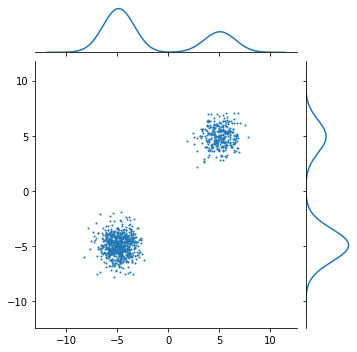

In [4]:
import seaborn as sns

x = pmc.results['samples']
g = sns.JointGrid(height=5)
g.ax_joint.scatter(x[:, 0], x[:, 1], s=1.0)
sns.kdeplot(x=x[:, 0], ax=g.ax_marg_x)
sns.kdeplot(y=x[:, 1], ax=g.ax_marg_y)
plt.show()

The trace plot shows PMC evolves the particles in each dimension.

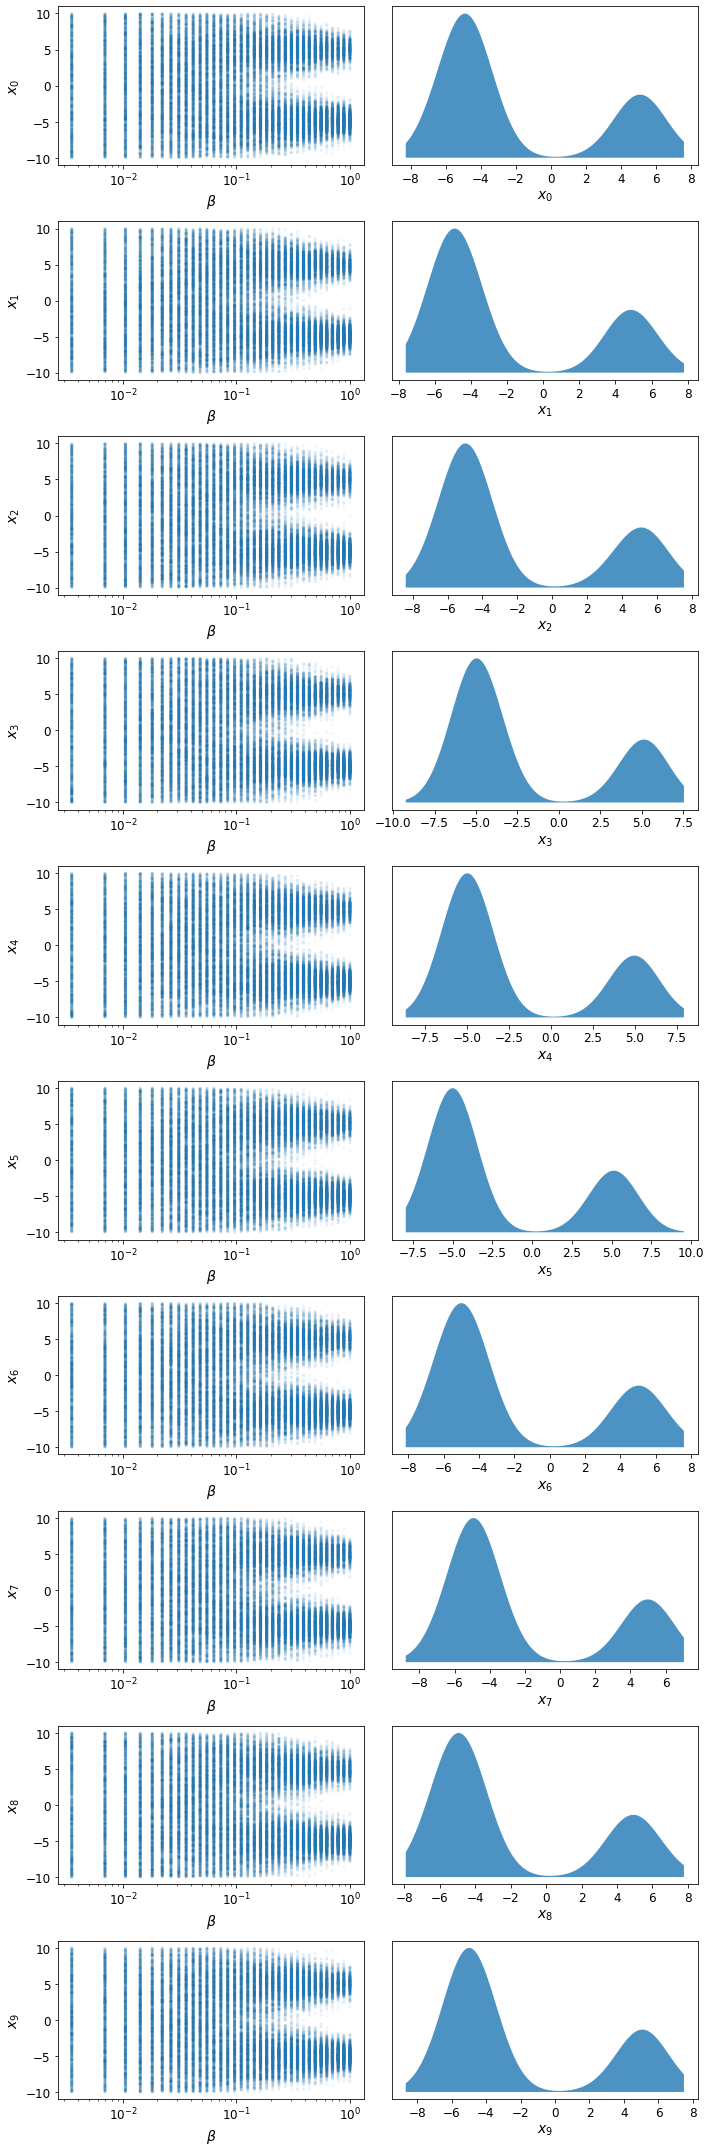

In [5]:
pc.plotting.trace(pmc.results)
plt.show()

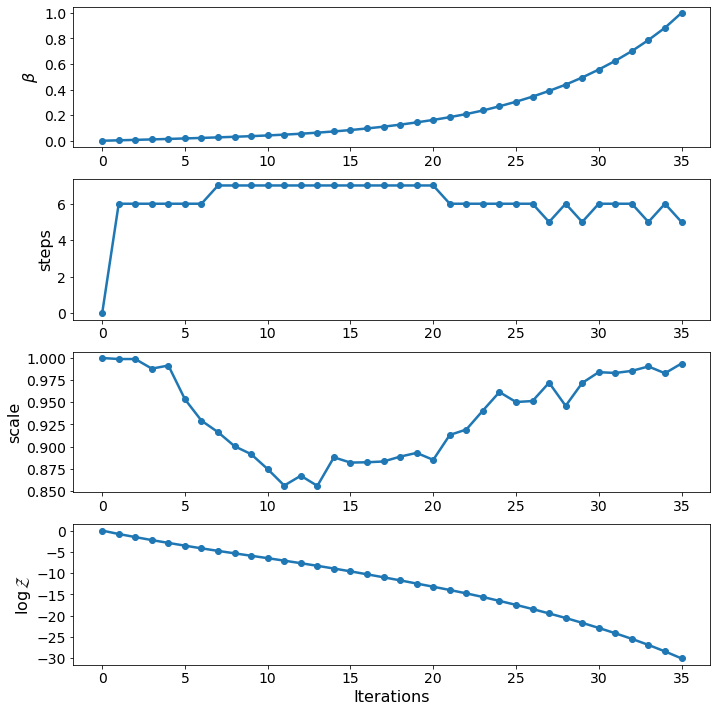

In [6]:
pc.plotting.run(pmc.results)
plt.show()